In [ ]:
# Mount Google Drive to access and store files in '/content/gdrive'
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Change working directory
import os
# TODO: Specify your path here
new_directory = "/content/gdrive/Othercomputers/Mein MacBook Pro/Drive/dl_proj"
os.chdir(new_directory)
print("Current Working Directory:", os.getcwd())

Current Working Directory: /content/gdrive/Othercomputers/Mein MacBook Pro/Drive/dl_proj


In [ ]:
# imports
import torch
from torch.nn import CrossEntropyLoss
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from utils.metrics import topk_acc, real_acc, AverageMeter

from models.networks import get_model
from data_utils.data_stats import *

import matplotlib.pyplot as plt

In [62]:
dataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture = 'B_12-Wi_1024'
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
num_classes = CLASS_DICT[dataset]
#data_path = './beton/'
eval_batch_size = 1024
checkpoint = 'in21k_cifar10'        # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10

In [63]:
# TODO: Do not forget to choose GPU as runtime
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# TODO: Create a folder called 'checkpoints'. It is already included in the .gitignore file
# Define the model and specify the pre-trained weights
model = get_model(architecture=architecture, resolution=crop_resolution, num_classes=num_classes, checkpoint=checkpoint)
model.cuda()

100% (453769295 of 453769295) |##########| Elapsed Time: 0:00:05 Time:  0:00:05


Load_state output <All keys matched successfully>


BottleneckMLP(
  (linear_in): Linear(in_features=12288, out_features=1024, bias=True)
  (linear_out): Linear(in_features=1024, out_features=100, bias=True)
  (blocks): ModuleList(
    (0-11): 12 x BottleneckBlock(
      (block): Sequential(
        (0): Linear(in_features=1024, out_features=4096, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=4096, out_features=1024, bias=True)
      )
    )
  )
  (layernorms): ModuleList(
    (0-11): 12 x LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
)

In [64]:
transform = transforms.Compose([
    transforms.Resize((crop_resolution, crop_resolution)),
    transforms.ToTensor(),
])

In [65]:
# ./data folder is ot uploaded to Github. See .gitignore
cifar10_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
loader = DataLoader(cifar10_dataset, batch_size=eval_batch_size, shuffle=True)


cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

100%|██████████| 169001437/169001437 [00:02<00:00, 62323875.56it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


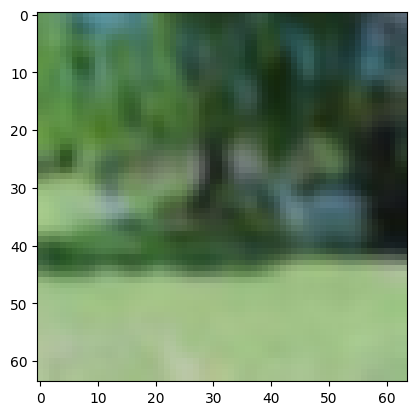

In [66]:
# select test image
image_nr = 300

# display image
image, true_label = cifar10_dataset[image_nr]
image = image.numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.show()

# prepare image to be processed by model
image, _ = cifar10_dataset[image_nr]
image = image.unsqueeze(0)
image = image.view(-1)
image = image.cuda()

In [69]:
model.eval()

with torch.no_grad():
    output = model(image)
    # print("Shape of the output tensor:", output.shape)

probabilities = torch.nn.functional.softmax(output, dim=0)
predicted_class = torch.argmax(probabilities).item()

predicted_label = cifar10_classes[predicted_class]
tr_label = cifar10_classes[true_label]

print(f"Model prediction:", predicted_label)
print(f"True label:      ", tr_label)

NameError: ignored

In [70]:
from utils.parsers import get_training_parser

parser = get_training_parser()
args = parser.parse_args(args=[])

In [71]:
loss_fn = CrossEntropyLoss(label_smoothing=args.smooth)

In [72]:
import time
from tqdm import tqdm
start = time.time()
model.eval()
total_acc, total_top5, total_loss = AverageMeter(), AverageMeter(), AverageMeter()

for ims, targs in tqdm(loader, desc="Evaluation"):
    targs = targs.cuda()
    ims = torch.reshape(ims, (ims.shape[0], -1)).cuda()
    preds = model(ims)

    if args.dataset != 'imagenet_real':
        acc, top5 = topk_acc(preds, targs, k=5, avg=True)
        loss = loss_fn(preds, targs).item()
    else:
        acc = real_acc(preds, targs, k=5, avg=True)
        top5 = 0
        loss = 0

    total_acc.update(acc, ims.shape[0])
    total_top5.update(top5, ims.shape[0])
    total_loss.update(loss)

end = time.time()

Evaluation: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


In [73]:
#print("Epoch", ep, "       Time:", train_time)
#print("-------------- Training ----------------")
#print("Average Training Loss:       ", "{:.6f}".format(train_loss))
#print("Average Training Accuracy:   ", "{:.4f}".format(train_acc))
#print("Top 5 Training Accuracy:     ", "{:.4f}".format(train_top5))
print("---------------- Test ------------------")
print("Test Accuracy        ", "{:.4f}".format(total_acc.get_avg(percentage=True)))
print("Top 5 Test Accuracy          ", "{:.4f}".format(total_top5.get_avg(percentage=True)))
print()

---------------- Test ------------------
Test Accuracy         45.5100
Top 5 Test Accuracy           71.1500

